<a href="https://colab.research.google.com/github/choccoba/hbv-tahoe-analysis/blob/main/Step1_HBV_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 HBV Tahoe-x1 분석 - 실제 데이터 (메모리 효율 버전)

**목적**: GSE182159 대용량 데이터에 Tahoe-x1 적용 (메모리 최적화)

---

## ⚠️ 메모리 관리 전략

| 전략 | 설명 |
|------|------|
| **샘플링** | 전체 243K 중 일부만 분석 (옵션) |
| **Sparse Matrix** | 메모리 효율적 형식 유지 |
| **배치 처리** | 임베딩을 작은 배치로 추출 |
| **즉시 삭제** | 불필요한 변수 즉시 삭제 |

In [1]:
# @title STEP 1: 환경 설정
import os, sys, platform

# Colab 확인
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/tahoe-x1'
else:
    PROJECT_PATH = 'G:/내 드라이브/tahoe-x1'

DATA_PATH = f'{PROJECT_PATH}/viral_hepatitis/raw_data'
OUTPUT_PATH = f'{PROJECT_PATH}/viral_hepatitis/analysis_results'
os.makedirs(OUTPUT_PATH, exist_ok=True)

if IN_COLAB:
    os.chdir(PROJECT_PATH)
    sys.path.insert(0, PROJECT_PATH)
    print('📦 패키지 설치 중...')
    !pip install scanpy anndata einops omegaconf igraph leidenalg boto3 mosaicml transformers -q
    !pip install -e . -q

import gc
print(f'\n✅ STEP 1 완료!')
print(f'📁 데이터: {DATA_PATH}')
print(f'📁 결과: {OUTPUT_PATH}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 패키지 설치 중...
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tahoe-x1 (pyproject.toml) ... done

✅ STEP 1 완료!
📁 데이터: /content/drive/MyDrive/tahoe-x1/viral_hepatitis/raw_data
📁 결과: /content/drive/MyDrive/tahoe-x1/viral_hepatitis/analysis_results


In [2]:
# @title STEP 2: 전체 데이터 로드 (243K)
import scanpy as sc
import anndata as ad
import numpy as np
import scipy.sparse as sp

DATA_FILE = 'GSE182159_processed.h5ad'

# ========== 전체 데이터 분석 ==========
USE_SAMPLING = False  # ← False로 변경!
# =====================================

print(f'📊 전체 데이터 로딩: {DATA_FILE}')
print('⚠️ 대용량 데이터 - 시간이 걸릴 수 있습니다...\n')

adata = ad.read_h5ad(f'{DATA_PATH}/{DATA_FILE}')

print(f'✅ STEP 2 완료!')
print(f'   세포 수: {adata.n_obs:,}')
print(f'   유전자 수: {adata.n_vars:,}')
print(f'\n📊 HBV Stage 분포:')
if 'hbv_stage' in adata.obs.columns:
    print(adata.obs['hbv_stage'].value_counts())
elif 'Stage' in adata.obs.columns:
    print(adata.obs['Stage'].value_counts())

📊 전체 데이터 로딩: GSE182159_processed.h5ad
⚠️ 대용량 데이터 - 시간이 걸릴 수 있습니다...

✅ STEP 2 완료!
   세포 수: 243,000
   유전자 수: 24,452

📊 HBV Stage 분포:
hbv_stage
IA    62545
IT    49179
AR    45452
AC    43245
NL    42579
Name: count, dtype: int64


In [3]:
# @title STEP 3: Tahoe-x1 모델 로드
import torch
from tqdm.auto import tqdm
from datetime import datetime

from tahoe_x1.model import ComposerTX
from tahoe_x1.utils.util import loader_from_adata

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_SIZE = '70m'

print(f'🖥️ Device: {DEVICE}')
print(f'🚀 Tahoe-x1 {MODEL_SIZE} 모델 로딩 중...')

model, vocab, model_cfg, collator_cfg = ComposerTX.from_hf(
    repo_id='tahoebio/Tahoe-x1',
    model_size=MODEL_SIZE,
    attn_impl='torch'
)
model.to(DEVICE).eval()

if DEVICE == 'cuda':
    torch.cuda.empty_cache()

print(f'\n✅ STEP 3 완료!')

🖥️ Device: cuda
🚀 Tahoe-x1 70m 모델 로딩 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



✅ STEP 3 완료!


In [6]:
# @title STEP 4: 데이터 전처리 (Gene Symbol → Ensembl ID 변환)
!pip install mygene -q

import mygene
import scanpy as sc
import numpy as np
import scipy.sparse as sp
import gc

print('🧬 데이터 전처리 시작...')

# 1. 데이터 다시 로드 (샘플링)
print('📊 데이터 로드 중...')
adata_full = ad.read_h5ad(f'{DATA_PATH}/GSE182159_processed.h5ad', backed='r')

np.random.seed(42)
SAMPLE_SIZE = 243000
if adata_full.n_obs > SAMPLE_SIZE:
    indices = np.random.choice(adata_full.n_obs, SAMPLE_SIZE, replace=False)
    indices = np.sort(indices)
else:
    indices = np.arange(adata_full.n_obs)

adata = adata_full[indices].to_memory()
del adata_full
gc.collect()
print(f'   로드 완료: {adata.n_obs:,} cells, {adata.n_vars:,} genes')

# 2. Gene Symbol → Ensembl ID 변환
print('\n🔄 Gene Symbol → Ensembl ID 변환 중...')
mg = mygene.MyGeneInfo()

gene_symbols = adata.var_names.tolist()
print(f'   변환할 유전자: {len(gene_symbols):,}개')

# 배치로 쿼리 (API 제한 고려)
results = mg.querymany(gene_symbols, scopes='symbol', fields='ensembl.gene', species='human', verbose=False)

# 매핑 딕셔너리 생성
symbol_to_ensembl = {}
for r in results:
    if 'ensembl' in r:
        ensembl = r['ensembl']
        if isinstance(ensembl, list):
            ensembl = ensembl[0]
        if isinstance(ensembl, dict) and 'gene' in ensembl:
            symbol_to_ensembl[r['query']] = ensembl['gene']

print(f'   변환 성공: {len(symbol_to_ensembl):,} / {len(gene_symbols):,} genes')

# 3. 유전자명 변환 적용
new_var_names = []
for g in adata.var_names:
    if g in symbol_to_ensembl:
        new_var_names.append(symbol_to_ensembl[g])
    else:
        new_var_names.append(g)  # 변환 실패 시 원본 유지

adata.var['original_symbol'] = adata.var_names.tolist()
adata.var_names = new_var_names
adata.var_names_make_unique()

# 4. Vocab 매핑
print('\n🔗 Vocab 매핑 중...')
vocab_ids = np.array([vocab.token_to_index.get(g, -1) for g in adata.var_names])
adata.var['id_in_vocab'] = vocab_ids

valid_mask = vocab_ids >= 0
print(f'   Vocab 매핑: {valid_mask.sum():,} / {len(valid_mask):,} genes')

adata = adata[:, valid_mask].copy()

# 5. 빈 세포 필터링
print('\n🧹 빈 세포 필터링 중...')
if sp.issparse(adata.X):
    gene_counts = np.array((adata.X > 0).sum(axis=1)).flatten()
else:
    gene_counts = (adata.X > 0).sum(axis=1)

min_genes = 10
valid_cells = gene_counts >= min_genes
adata = adata[valid_cells].copy()

print(f'   유효 세포: {valid_cells.sum():,} / {len(valid_cells):,}')

# 기본 필터링
sc.pp.filter_genes(adata, min_cells=3)

gc.collect()

print(f'\n✅ STEP 4 완료!')
print(f'   최종 데이터: {adata.shape}')

🧬 데이터 전처리 시작...
📊 데이터 로드 중...


   로드 완료: 243,000 cells, 24,452 genes

🔄 Gene Symbol → Ensembl ID 변환 중...
   변환할 유전자: 24,452개
   변환 성공: 18,264 / 24,452 genes

🔗 Vocab 매핑 중...
   Vocab 매핑: 17,540 / 24,452 genes

🧹 빈 세포 필터링 중...
   유효 세포: 243,000 / 243,000

✅ STEP 4 완료!
   최종 데이터: (243000, 16832)


In [7]:
# @title STEP 5: 임베딩 추출 (수정됨)
BATCH_SIZE = 16  # A100은 더 큰 배치 가능

print(f'🧠 임베딩 추출 (배치: {BATCH_SIZE})')
print(f'   세포 수: {adata.n_obs:,}')

loader = loader_from_adata(
    adata=adata,
    collator_cfg=collator_cfg,
    vocab=vocab,
    batch_size=BATCH_SIZE,
    num_workers=0,  # 에러 디버깅용 - 성공 후 2로 변경 가능
    prefetch_factor=None
)

all_embeddings = []
with torch.no_grad():
    for batch in tqdm(loader, desc='추출 중'):
        batch = {k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v
                 for k, v in batch.items()}
        output = model(batch, skip_decoders=True)
        all_embeddings.append(output['cell_emb'].cpu().numpy())

        del output, batch
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()

embeddings = np.vstack(all_embeddings)
del all_embeddings
gc.collect()

adata.obsm[f'X_tahoe_{MODEL_SIZE}'] = embeddings

print(f'\n✅ STEP 5 완료!')
print(f'   임베딩 차원: {embeddings.shape}')

🧠 임베딩 추출 (배치: 16)
   세포 수: 243,000


추출 중:   0%|          | 0/15188 [00:00<?, ?it/s]


✅ STEP 5 완료!
   임베딩 차원: (243000, 512)


🗺️ UMAP 및 클러스터링...


/tmp/ipython-input-944448043.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


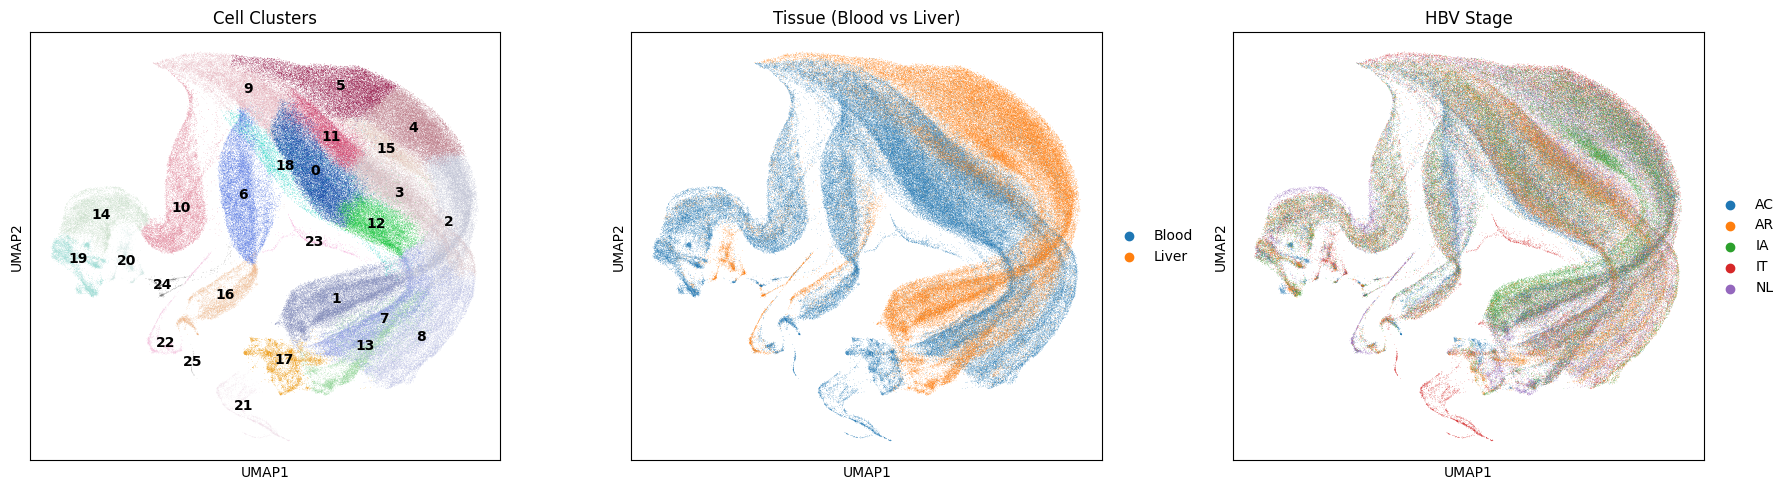


✅ STEP 6 완료!


In [8]:
# @title STEP 6: UMAP 및 클러스터링
import matplotlib.pyplot as plt

print('🗺️ UMAP 및 클러스터링...')

sc.pp.neighbors(adata, use_rep=f'X_tahoe_{MODEL_SIZE}')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False,
           title='Cell Clusters', legend_loc='on data')

if 'tissue' in adata.obs.columns:
    sc.pl.umap(adata, color='tissue', ax=axes[1], show=False,
               title='Tissue (Blood vs Liver)')

stage_col = 'hbv_stage' if 'hbv_stage' in adata.obs.columns else 'Stage'
if stage_col in adata.obs.columns:
    sc.pl.umap(adata, color=stage_col, ax=axes[2], show=False,
               title='HBV Stage')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/hbv_real_umap_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n✅ STEP 6 완료!')

🔬 세포 유형 분석 중...



📊 마커 유전자: 27개
   변환 성공: 27/27
   사용 가능한 세포 유형: 11

📊 클러스터별 세포 유형:
  클러스터  0: CD4+ T cells         (21342개 세포, score: 1.6393)
  클러스터  1: CD8+ T cells         (19782개 세포, score: 1.6524)
  클러스터  2: CD8+ T cells         (19659개 세포, score: 1.3287)
  클러스터  3: NK cells             (18862개 세포, score: 2.3555)
  클러스터  4: CD8+ T cells         (17796개 세포, score: 1.2892)
  클러스터  5: CD8+ T cells         (14938개 세포, score: 1.1902)
  클러스터  6: B cells              (13558개 세포, score: 2.7616)
  클러스터  7: CD4+ T cells         (13531개 세포, score: 1.7512)
  클러스터  8: NK cells             (12848개 세포, score: 2.3245)
  클러스터  9: CD4+ T cells         (12592개 세포, score: 1.0786)
  클러스터 10: CD14+ Monocytes      (10913개 세포, score: 3.5335)
  클러스터 11: NK cells             (10133개 세포, score: 2.2757)
  클러스터 12: CD4+ T cells         ( 9901개 세포, score: 1.7174)
  클러스터 13: NK cells             ( 8087개 세포, score: 2.1882)
  클러스터 14: CD14+ Monocytes      ( 8067개 세포, score: 3.2672)
  클러스터 15: NK cells             ( 6613개 세포, score

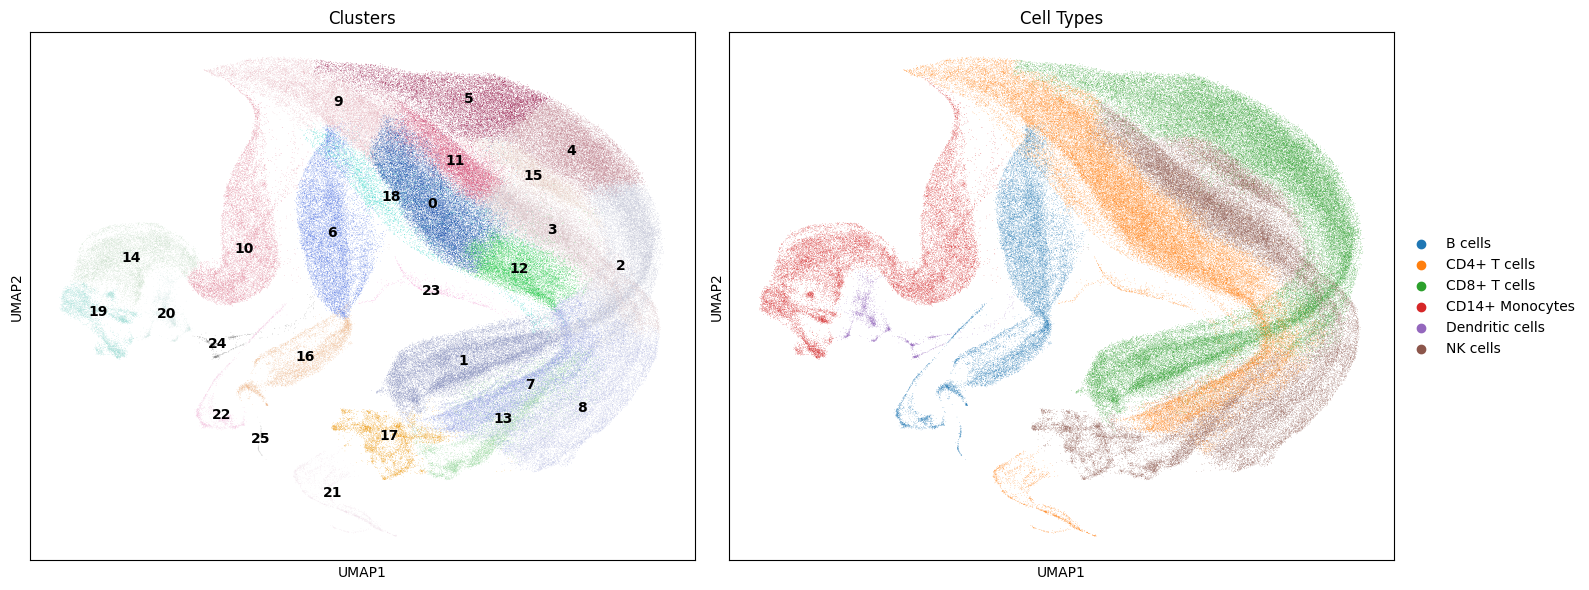


✅ STEP 7 완료!

📊 세포 유형 분포:
cell_type
CD8+ T cells       72175
CD4+ T cells       64119
NK cells           61309
CD14+ Monocytes    23191
B cells            20196
Dendritic cells     2010
Name: count, dtype: int64


In [9]:
# @title STEP 7: 세포 유형 식별 (Ensembl ID 버전)
import scipy.sparse as sp

print('🔬 세포 유형 분석 중...\n')

# Gene Symbol → Ensembl ID 변환 (마커용)
!pip install mygene -q
import mygene
mg = mygene.MyGeneInfo()

# PBMC + Liver 마커 (Gene Symbol)
markers_symbol = {
    'CD4+ T cells': ['CD3D', 'CD4', 'IL7R'],
    'CD8+ T cells': ['CD3D', 'CD8A', 'CD8B'],
    'B cells': ['MS4A1', 'CD79A', 'CD79B'],
    'NK cells': ['GNLY', 'NKG7', 'NCAM1'],
    'CD14+ Monocytes': ['CD14', 'LYZ', 'S100A8'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic cells': ['FCER1A', 'CST3'],
    'Platelets': ['PPBP', 'PF4'],
    'Hepatocytes': ['ALB', 'APOA1', 'HP'],
    'Kupffer cells': ['CD68', 'MARCO'],
    'Endothelial': ['PECAM1', 'VWF']
}

# 모든 마커 유전자 수집
all_markers = set()
for genes in markers_symbol.values():
    all_markers.update(genes)

print(f'📊 마커 유전자: {len(all_markers)}개')

# Gene Symbol → Ensembl ID 변환
results = mg.querymany(list(all_markers), scopes='symbol', fields='ensembl.gene', species='human', verbose=False)

symbol_to_ensembl = {}
for r in results:
    if 'ensembl' in r:
        ensembl = r['ensembl']
        if isinstance(ensembl, list):
            ensembl = ensembl[0]
        if isinstance(ensembl, dict) and 'gene' in ensembl:
            symbol_to_ensembl[r['query']] = ensembl['gene']

print(f'   변환 성공: {len(symbol_to_ensembl)}/{len(all_markers)}')

# Ensembl ID로 마커 변환
markers = {}
for cell_type, genes in markers_symbol.items():
    ensembl_genes = [symbol_to_ensembl.get(g) for g in genes if symbol_to_ensembl.get(g)]
    if ensembl_genes:
        markers[cell_type] = ensembl_genes

print(f'   사용 가능한 세포 유형: {len(markers)}')

# 클러스터별 세포 유형 식별
print('\n📊 클러스터별 세포 유형:')
cluster_types = {}
for cluster in sorted(adata.obs['leiden'].unique(), key=lambda x: int(x)):
    cluster_cells = adata[adata.obs['leiden'] == cluster]
    best_type, best_score = 'Unknown', 0

    for cell_type, genes in markers.items():
        valid_genes = [g for g in genes if g in adata.var_names]
        if valid_genes:
            X_subset = cluster_cells[:, valid_genes].X
            if sp.issparse(X_subset):
                score = X_subset.toarray().mean()
            else:
                score = X_subset.mean()
            if score > best_score:
                best_score, best_type = score, cell_type

    cluster_types[cluster] = best_type
    n_cells = len(cluster_cells)
    print(f'  클러스터 {cluster:>2}: {best_type:<20} ({n_cells:>5}개 세포, score: {best_score:.4f})')

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_types)

# 시각화
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False,
           title='Clusters', legend_loc='on data')
sc.pl.umap(adata, color='cell_type', ax=axes[1], show=False,
           title='Cell Types')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/hbv_real_cell_types.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n✅ STEP 7 완료!')
print(f'\n📊 세포 유형 분포:')
print(adata.obs['cell_type'].value_counts())

In [10]:
# @title STEP 8: 결과 저장
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sample_tag = f'_{SAMPLE_SIZE//1000}k' if USE_SAMPLING else '_full'
output_file = f'{OUTPUT_PATH}/hbv_real_tahoe_analysis{sample_tag}_{timestamp}.h5ad'

adata.write_h5ad(output_file)

print('=' * 60)
print('🎉 GSE182159 실제 데이터 Tahoe-x1 분석 완료!')
print('=' * 60)
print(f'\n📁 저장된 파일:')
print(f'   📊 {output_file}')
print(f'   🖼️ {OUTPUT_PATH}/hbv_real_umap_overview.png')
print(f'   🖼️ {OUTPUT_PATH}/hbv_real_cell_types.png')
print(f'\n📋 분석 요약:')
print(f'   세포 수: {adata.n_obs:,}')
print(f'   클러스터 수: {adata.obs["leiden"].nunique()}')
print(f'\n📊 조직별 세포 수:')
print(adata.obs['tissue'].value_counts())
print('\n✅ 다음 단계: Step2_HBV_group_comparison.ipynb 실행')

🎉 GSE182159 실제 데이터 Tahoe-x1 분석 완료!

📁 저장된 파일:
   📊 /content/drive/MyDrive/tahoe-x1/viral_hepatitis/analysis_results/hbv_real_tahoe_analysis_full_20260113_084251.h5ad
   🖼️ /content/drive/MyDrive/tahoe-x1/viral_hepatitis/analysis_results/hbv_real_umap_overview.png
   🖼️ /content/drive/MyDrive/tahoe-x1/viral_hepatitis/analysis_results/hbv_real_cell_types.png

📋 분석 요약:
   세포 수: 243,000
   클러스터 수: 26

📊 조직별 세포 수:
tissue
Blood    136408
Liver    106592
Name: count, dtype: int64

✅ 다음 단계: Step2_HBV_group_comparison.ipynb 실행
